In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

In [13]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)

import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    inter_bmu = yaml.safe_load(f)['interconnection_mapper']

intercon_lats = []

for i, (key, item) in enumerate(inter_bmu.items()):

    if key == 'Nemo':
        intercon_lats.append(0)
        continue

    lat = bmus.loc[bmus.index.str.startswith(item[0]+'-'), 'lat'].dropna().astype(float).mean()
    intercon_lats.append(lat)

intercon_lats = pd.Series(intercon_lats, index=inter_bmu.keys())

intercon_lats.loc['EastWest'] = 53.23
intercon_lats.loc['Moyle'] = 55.07
intercon_lats.loc['Nemo'] = 51.297

intercon_lats = intercon_lats.to_frame().rename(columns={0: 'lat'})

In [16]:
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0
)
bmus = bmus.loc[bmus['bus'] != 'distributed']

bmus.loc[:,'lat'] = bmus['lat'].astype(float)
bmus.loc[:,'lon'] = bmus['lon'].astype(float)

bmus = bmus[['lon', 'lat']]

In [17]:
bmus

,lon,lat
NationalGridBmUnit,,
IBG-EGEN1,0.653,51.46
IBG-ENGI1,0.653,51.46
IBG-RSQ1,0.653,51.46
IVD-VKL1,-0.221,52.931
IVG-VKL1,-0.221,52.931
...,...,...
GRGBW-2,1.713867,52.066
GRGBW-3,1.713867,52.066
SGRWO-1,-1.741,56.588


In [21]:
z = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv'
n = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv'

z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
n = pd.read_csv(n, parse_dates=True, index_col=[0,1])

n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
z_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

n_total = n_total[n_total > 0]
zonal_total = z_total.loc[n_total.index]

diff = (zonal_total - n_total).clip(lower=-1, upper=1)

C:\Users\lukas\AppData\Local\Temp\ipykernel_30848\4106984488.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30848\4106984488.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30848\4106984488.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n = pd.read_csv(n, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30848\4106984488.py:5: UserWarning:

In [30]:
intersec = bmus.index.intersection(diff.index)

gseries = gpd.GeoDataFrame(diff.loc[intersec], geometry=gpd.points_from_xy(bmus.loc[intersec, 'lon'], bmus.loc[intersec, 'lat'])).rename(columns={0: 'diff'})

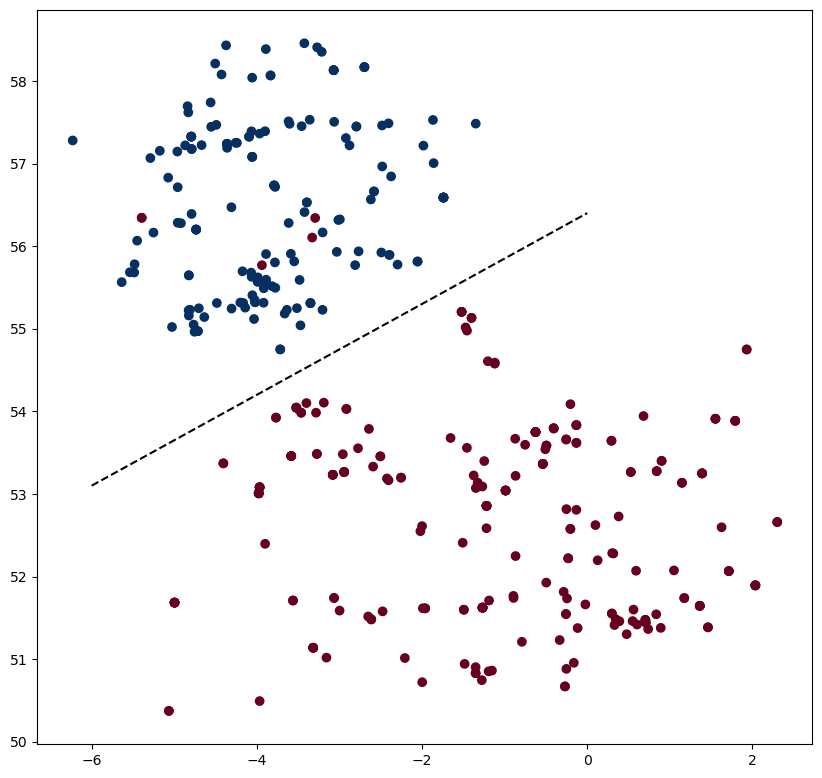

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

gseries.plot(ax=ax, column='diff', cmap='RdBu_r')

tangent_x = np.linspace(-6, 0, 2)
tangent_y = 0.55 * tangent_x + 56.4

ax.plot(tangent_x, tangent_y, 'k--', label='Tangent')

plt.show()

In [19]:
import logging

logger = logging.getLogger(__name__)

import urllib
import requests
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True) # related to .replace(..) replacing .fillna()

from tqdm import tqdm
from functools import wraps

from io import StringIO
from typing import Iterable, Tuple, List
from entsoe import EntsoePandasClient

def to_datetime(day, period):
    return pd.Timestamp(day, tz='Europe/London').tz_convert('utc') + pd.Timedelta(minutes=30) * (period - 1)


######################    BALANCING ACTIONS    ##############################
# to get bm units that have been accepted by the system operator
accepts_url = (
    'https://data.elexon.co.uk/bmrs/api/v1/balancing/acceptances/' +
    'all?settlementDate={}&settlementPeriod={}&format=csv'
    )
# to get volumes of bids of offers for accepted bm units
volumes_url = (
    "https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/"
    "indicative/volumes/all/{}/{}/{}?format=json&{}"
)
# to get prices of bids and offers
trades_url = (
        'https://data.elexon.co.uk/bmrs/api/v1/balancing/bid-offer/' +
        'all?settlementDate={}&settlementPeriod={}&format=csv'
    )


def get_accepted_units(date, period, so_only=False):

    response = requests.get(accepts_url.format(date, period))
    response.raise_for_status()
    
    acc = pd.read_csv(StringIO(response.text))

    if so_only:
        acc = acc.loc[acc.SoFlag]

    corrected = []

    for bm in acc.NationalGridBmUnit.unique():

        ss = acc.loc[acc.NationalGridBmUnit == bm]
        ss = ss.loc[ss.AcceptanceTime == ss.AcceptanceTime.max()]
        corrected.append(ss)

    try:
        return pd.concat(corrected).NationalGridBmUnit.unique()
    except ValueError:
        return np.array([], dtype=str)


def get_volumes(date, period):

    units = get_accepted_units(date, period)
    unit_params = '&'.join(f"bmUnit={urllib.parse.quote_plus(unit)}" for unit in units)

    data = list()

    for mode in ['offer', 'bid']:
    
        response = requests.get(volumes_url.format(mode, date, period, unit_params))
        response.raise_for_status()

        volumes_json = response.json()
        if 'data' in volumes_json:
            volumes_df = pd.json_normalize(volumes_json['data'])
        else:
            volumes_df = pd.DataFrame()

        data.append(volumes_df)

    return pd.concat(data)


def get_trades(date, period):

    units = get_accepted_units(date, period)

    response = requests.get(trades_url.format(date, period))
    response.raise_for_status()
    trades_df = pd.read_csv(StringIO(response.text))

    return trades_df[trades_df['NationalGridBmUnit'].isin(units)]


_cache = {}
_calls_remaining = {}

# both bids and offers build on the same data, so we cache the volumes and trades
def _cache_volumes_trades(func):
    @wraps(func)
    def wrapper(date, period):
        key = (date, period)
        if key not in _cache:

            _cache[key] = {}
            _cache[key]['v'] = get_volumes(date, period)
            _cache[key]['t'] = get_trades(date, period)

            _calls_remaining[key] = {'get_volumes': True, 'get_trades': True}

        result = func(_cache[key]['v'], _cache[key]['t'], date, period)
        _cleanup(func.__name__, key)
        return result
    return wrapper


def _cleanup(func_name, key):
    _calls_remaining[key][func_name] = False
    if not any(_calls_remaining[key].values()):
        del _cache[key]
        del _calls_remaining[key]


def build_bm_actions_period(action, volumes, trades, date, period):

    vol_marker = {'bids': 'negative', 'offers': 'positive'}[action]
    
    def get_unit_trades(action, df):
        if action == 'bids':
            return df.loc[df.PairId < 0, 'Bid'].iloc[::-1]
        elif action == 'offers':
            return df.loc[df.PairId > 0, 'Offer']

    if volumes.empty:
        return pd.DataFrame(
            columns=pd.MultiIndex.from_product(
                [[to_datetime(date, period)], ['vol', 'price']]
            )
        )

    cols = volumes.columns[volumes.columns.str.contains(vol_marker)].tolist()
    detected_actions = list()

    for bm in volumes.nationalGridBmUnit.unique():

        unit_volumes = volumes.loc[volumes.nationalGridBmUnit == bm]
        unit_trades = trades.loc[trades.NationalGridBmUnit == bm]

        row = unit_volumes[['dataType'] + cols]
        row = (
            row.loc[row['dataType'] == 'Tagged', cols]
            .replace(np.nan, 0)
            .abs()
            .max()
        )

        bm_trades = get_unit_trades(action, unit_trades)

        for trade_price, trade_vol in zip(bm_trades, row.loc[row != 0].values):
            detected_actions.append(pd.Series({
                'vol': trade_vol,
                'price': trade_price
            }, name=bm))

    def process_multiples(df):
        return df.groupby(df.index).apply(
            lambda x: pd.Series({
                'vol': x['vol'].sum(),
                'price': (x['vol'] * x['price']).sum() / x['vol'].sum()
            })
        )

    try:
        detected_actions = process_multiples(
            pd.concat(detected_actions, axis=1).T
        )
    except ValueError:
        detected_actions = pd.DataFrame(columns=['vol', 'price'])

    if action == 'bids':
        detected_actions['price'] = -detected_actions['price']

    detected_actions.columns = (
        pd.MultiIndex.from_product(
            [[to_datetime(date, period)], detected_actions.columns]
            )
    )

    return detected_actions


@_cache_volumes_trades
def build_offers_period(*args):
    return build_bm_actions_period('offers', *args)


@_cache_volumes_trades
def build_bids_period(*args):
    return build_bm_actions_period('bids', *args)


build_offers_period('2009-01-21', 20)

Empty DataFrame
Columns: [(2009-01-21 09:30:00+00:00, vol), (2009-01-21 09:30:00+00:00, price)]
Index: []